### Imports

In [3]:
# system imports
import os, re
import sys
import json
import math
from math import sqrt

# data science
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# from matplotlib.patches import Ellipse
# import matplotlib.animation as animation
# from numpy.lib.utils import show_runtime
# import matplotlib.lines as mlines

# signal processing
from scipy import signal
from scipy.ndimage import label
from scipy.signal import savgol_filter

from scipy.stats import zscore
from scipy.interpolate import interp1d
# from scipy.integrate import trapz
# from scipy.signal import butter, filtfilt

# physionet data
# import wfdb
# from wfdb import processing

from biosppy.signals import ecg, hrv, ppg, acc, eda
from biosppy import inter_plotting
from scipy.interpolate import CubicSpline
from scipy.stats import zscore
import biosppy.signals.hrv as hrv

import seaborn as sns
import warnings

# import wfdb
import pywt
import math
from sklearn.metrics import mean_squared_error

import ipywidgets as widgets
from IPython.display import display

from utils import *

warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=Warning)  # Suppress BioSPPy warnings

print("numpy version (should be < 2)")
np.version.version ## should be < 2

numpy version (should be < 2)


'1.26.4'

### Global settings

In [2]:
# path settings
project_path = os.path.join(os.getcwd(), os.pardir)
data_path = os.path.join(project_path, 'data')
output_path = os.path.join(project_path, 'output')

# style settings
sns.set(style='whitegrid', rc={'axes.facecolor': '#EFF2F7'})

# sample frequency for Bobbi sensor
settings = {}
settings['fs'] = 500

identifiers = "s1_SHE_T1,s1_SHE_T2,s1_SHE_T3,s1_HE_T4,s1_HE_T5,s1_HE_T6,s2_HE_T1,s2_HE_T2,s2_HE_T3,s2_SHE_T4,s2_SHE_T5,s2_SHE_T6,s2_SHE_T7,s3_SHE_T1,s3_SHE_T2,s3_SHE_T3,s3_HE_T4,s3_HE_T5,s3_HE_T6,s4_HE_T1,s4_HE_T2,s4_HE_T3,s4_SHE_T4,s4_SHE_T5,s4_SHE_T6,s5_SHE_T1,s5_SHE_T2,s5_SHE_T3,s5_HE_T4,s5_HE_T5,s5_HE_T6,s6_HE_T1,s6_HE_T2,s6_HE_T3,s6_SHE_T4,s6_SHE_T5,s6_SHE_T6"
identifiers = [id[:-3] for id in  identifiers.split(",")]
identifiers = list(dict.fromkeys(identifiers))
print(identifiers)

take_1_timestamps = {
    "blackscreen_s1_SHE.mov": 35.250000,
    "blackscreen_s1_HE.mov": 25.375000,
    "blackscreen_s2_HE.mov": 57.250000,
    "blackscreen_s2_SHE.mov": 37.333333,
    "blackscreen_s3_SHE.mov": 60.333333,
    "blackscreen_s3_HE.mov": 52.416667,
    "blackscreen_resting1.mov": 0.0,
    "blackscreen_resting2.mov": 0.0,
    "blackscreen_resting3.mov": 0.0,
    "blackscreen_resting4.mov": 0.0,
    "blackscreen_resting5.mov": 0.0,
    "blackscreen_resting6.mov": 0.0,
    "blackscreen_s4_HE.mov": 56.208333,
    "blackscreen_s4_SHE.mov": 194.250000,
    "blackscreen_s5_SHE.mov": 285.250000,
    "blackscreen_s5_HE.mov": 76.250000,
    "blackscreen_s6_HE.mov": 96.208333,
    "blackscreen_s6_SHE.mov": 34.333333,
}
list(take_1_timestamps.values())[:]

label_options = widgets.ToggleButtons(
    options=['ECG', 'PPG', 'EDA', 'ACC'],
    description='Modality:',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltips=['Description of slow', 'Description of regular', 'Description of fast'],
    #     icons=['check'] * 3
)

# Display the dropdown widget
display(label_options)

['s1_SHE', 's1_HE', 's2_HE', 's2_SHE', 's3_SHE', 's3_HE', 's4_HE', 's4_SHE', 's5_SHE', 's5_HE', 's6_HE', 's6_SHE']


ToggleButtons(description='Modality:', options=('ECG', 'PPG', 'EDA', 'ACC'), tooltips=('Description of slow', …

### Times for Synchronisation

In [3]:
takes_start_time_s = [[35.255, 208.39499999999998, 375.365], [25.365, 172.235, 328.295], [57.255, 303.33500000000004, 514.325], [37.325, 257.225, 473.41499999999996, 743.2750000000001], [60.335, 313.325, 477.375], [52.405, 567.2149999999999, 822.365],
                      [56.195, 230.255, 555.235], [194.245, 390.225, 545.255], [285.225, 457.19500000000005, 692.175], [76.245, 408.40500000000003, 614.395], [96.195, 304.255, 454.34499999999997], [34.345, 180.395, 520.335]]

film_durations = [[73.962667, 84.629333, 73.589333], [70.912000, 69.760000, 64.640000],
                  [83.520000, 84.352000, 86.357333], [97.664000, 110.357333, 114.517333, 113.344000],
                  [59.626667, 63.594667, 68.906667], [59.840000, 60.906667, 62.442667],
                  [69.077333, 74.880000, 74.474667], [88.384000, 77.120000, 66.026667],
                  [68.714667, 74.837333, 70.037333], [72.064000, 64.832000, 59.349333],
                  [104.704000, 70.869333, 75.669333], [86.272000, 124.842667, 80.597333]]

## Load data

In [10]:
file_dir = "../Data/Sensors/"

def get_json_files(directory):
  json_files = []
  for root, _, files in os.walk(directory):
    for file in files:
      if file.endswith(".json"):
        json_files.append(os.path.join(root, file))
  return json_files

def filter_strings_by_substrings(strings, substrings):
    return [s for s in strings if not any(sub.lower() in s.lower() for sub in substrings)]

def filter_dict_keys_by_substrings(data: dict, substrings: list) -> dict:
    return {
        key: value
        for key, value in data.items()
        if not any(sub in key for sub in substrings)
    }

json_files_list = sorted(get_json_files(file_dir))
filtered_json_files_list = filter_strings_by_substrings(json_files_list, ["Resting", "s7"])
for json_file, i in enumerate(filtered_json_files_list):
    print(json_file, i)


filtered_take_1_timestamps = filter_dict_keys_by_substrings(take_1_timestamps, ["resting"])
print(list(filtered_take_1_timestamps.values())[:])

# Open and read the JSON file
def get_json_data (file_name):
    with open(file_name, 'r') as file:
        data = json.load(file)
        return data

def get_duration(data):
    total_duration = data[-1]['time']
    print(total_duration / 60)

def zero_until_range(data, start_index, last_end_index):
    zero = [0.55, 0.55, 0.55]
    print(start_index, last_end_index)
    return [zero if i < start_index and i >= last_end_index else data[i] for i in range(len(data))]

def get_masked_ranges(start_times, durations, length):
    ranges = [(start, start + duration - 1) for start, duration in zip(start_times, durations)]
    ranges.append(np.array([ranges[-1][1], length]))
    return ranges

0 ../Data/Sensors/Day_1/s1/recordings-102224-10_53_51.json
1 ../Data/Sensors/Day_1/s1/recordings-102224-11_31_23.json
2 ../Data/Sensors/Day_1/s2/._recordings-102224-13_55_08.json
3 ../Data/Sensors/Day_1/s2/recordings-102224-12_54_59.json
4 ../Data/Sensors/Day_1/s2/recordings-102224-13_55_08.json
5 ../Data/Sensors/Day_1/s3/recordings-102224-14_49_27.json
6 ../Data/Sensors/Day_1/s3/recordings-102224-15_41_51.json
7 ../Data/Sensors/Day_2/s4/recordings-102324-09_46_10.json
8 ../Data/Sensors/Day_2/s4/recordings-102324-10_42_20.json
9 ../Data/Sensors/Day_2/s5/recordings-102324-12_10_52.json
10 ../Data/Sensors/Day_2/s5/recordings-102324-12_55_16.json
11 ../Data/Sensors/Day_2/s6/recordings-102324-13_41_18.json
12 ../Data/Sensors/Day_2/s6/recordings-102324-14_36_31.json
[35.25, 25.375, 57.25, 37.333333, 60.333333, 52.416667, 56.208333, 194.25, 285.25, 76.25, 96.208333, 34.333333]


## Explore dataset part 1
Open first file in the dataset. This took ~20 seconds on my iMac. Remove break to open all (longer loading time)

../Data/Sensors/Day_1/s1/recordings-102224-10_53_51.json 0
device data length:  (2, 101678)
8803 73791 64988


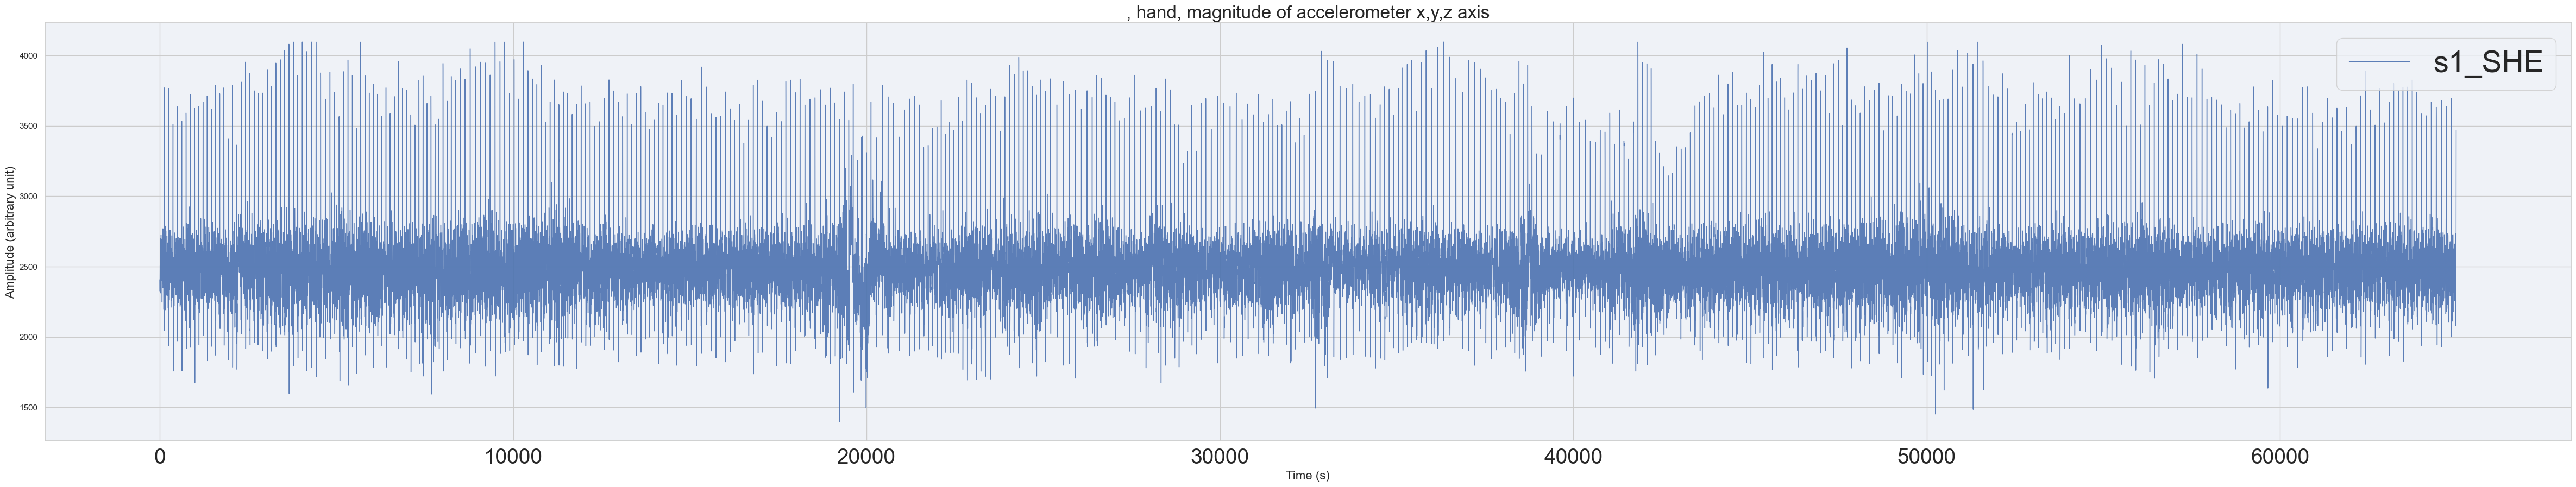

In [8]:
current_label = label_options.value
# current_label = "ECG"
trim = -1
DoP_ID = 0

#ACC
if (current_label == "ACC"):
    dev_id = 7
    channel = 0
#ECG
if (current_label == "ECG"):
    dev_id = 10
    channel = 12
#EDA
if (current_label == "EDA"):
    dev_id = 0
    channel = 12

start_time_seconds = 0

def get_data_from_json(file_ID, dev_id, channel, show_graph=True):
    data = get_json_data(filtered_json_files_list[file_ID])

    total_duration = data[-1]['time']

    # Extract addresses and find unique instances
    addresses = [item.get('address') for item in data if item.get('address')]

    unique_addresses = set(addresses)

    device_data = {address: [] for address in unique_addresses}
    data_timeline = {address: [] for address in unique_addresses}

    for item in data:
        address = item.get('address')
        id = re.search(r"/(\d+)/", address).group(1)
        data_timeline[address].append([item['time'], item['args']])

    for address in unique_addresses:
        times = [entry[0] for entry in data_timeline[address]]
        args = [entry[1] for entry in data_timeline[address]]
        device_data[address] = [times, args]

    try:
        device_data = np.asarray(device_data["/%s/raw" % dev_id], dtype="object")
        print("device data length: ", device_data.shape)
    except KeyError:
        if (current_label != "ACC"):
            return 0
        device_data = np.asarray(device_data["/%s/raw" % 3], dtype="object")
        print("device data length: ", device_data.shape)
    # Assuming graph contains [time, args]
    times = device_data[0]  # First part (e.g., time)
    if (channel == 0):
        sensors = [[entry[0][channel], entry[0][channel+1], entry[0][channel+2]] for entry in device_data[1]]  # Assuming entry[1] is the args part
        magnitude = [sqrt(pow(entry[0][channel], 2) + pow(entry[0][channel+1], 2) + pow(entry[0][channel+2], 2)) for entry in device_data[1]]
    else:
        sensors = [entry[0][channel] for entry in device_data[1]]  # Assuming entry[1] is the args part

    start_time_seconds = list(filtered_take_1_timestamps.values())[file_ID]
    # print("start_time_seconds: ", start_time_seconds)
    start_time_index = np.where(
        times==min(times, key=lambda x:abs(x-start_time_seconds)))[0][0]

    end_time_seconds = 260
    end_time_index = np.where(
        times==min(times, key=lambda x:abs(x-end_time_seconds)))[0][0] + start_time_index

    diff = end_time_index - start_time_index
    print(start_time_index, end_time_index, diff)

    sensors_graph = sensors[:trim]
    if (channel == 0):
        sensors_graph = magnitude[start_time_index:end_time_index]
    else:
        sensors_graph = sensors[start_time_index:end_time_index]

    # times_graph = times[start_time_index:end_time_index] - times[start_time_index]
    times_graph = np.arange(end_time_index - start_time_index)

    duration = times[trim]
    if show_graph:
        # plt.title("%s, %s, %s" % (identifiers[file_ID], "hand", "magnitude of accelerometer x,y,z axis"), fontsize=24)
        plt.plot(times_graph, sensors_graph, linewidth=1, alpha=0.90, label=identifiers[file_ID])
        plt.xticks(fontsize=28)
    # return times, sensors, duration
    return times, sensors, duration

plt.figure(figsize=(60, 10))
plt.title("%s, %s, %s" % ("", "hand", "magnitude of accelerometer x,y,z axis"), fontsize=24)
plt.xlabel("Time (s)", fontsize=16)
plt.ylabel("Amplitude (arbitrary unit)", fontsize=16)

DoP_ID = 0
# for jf_id, jf in enumerate(json_files_list[:-4]):
# print(filtered_json_files_list)
for jf_id, jf in enumerate(filtered_json_files_list[:]):
    if "Resting" not in jf:
        jf_id = filtered_json_files_list.index(jf)
        print (jf, jf_id)
        times, sensors, duration = get_data_from_json(jf_id, dev_id, channel)
        DoP_ID += 1
        break

plt.legend(loc="upper right", fontsize=40)
plt.show()

### Signal Processing - Peak Detecton

device data length:  (2, 101678)
8803 73791 64988
(8804, 27282) 0
(52087, 73231) 27282
(81562, 99947) 73231
[ 99947 101678] 99947


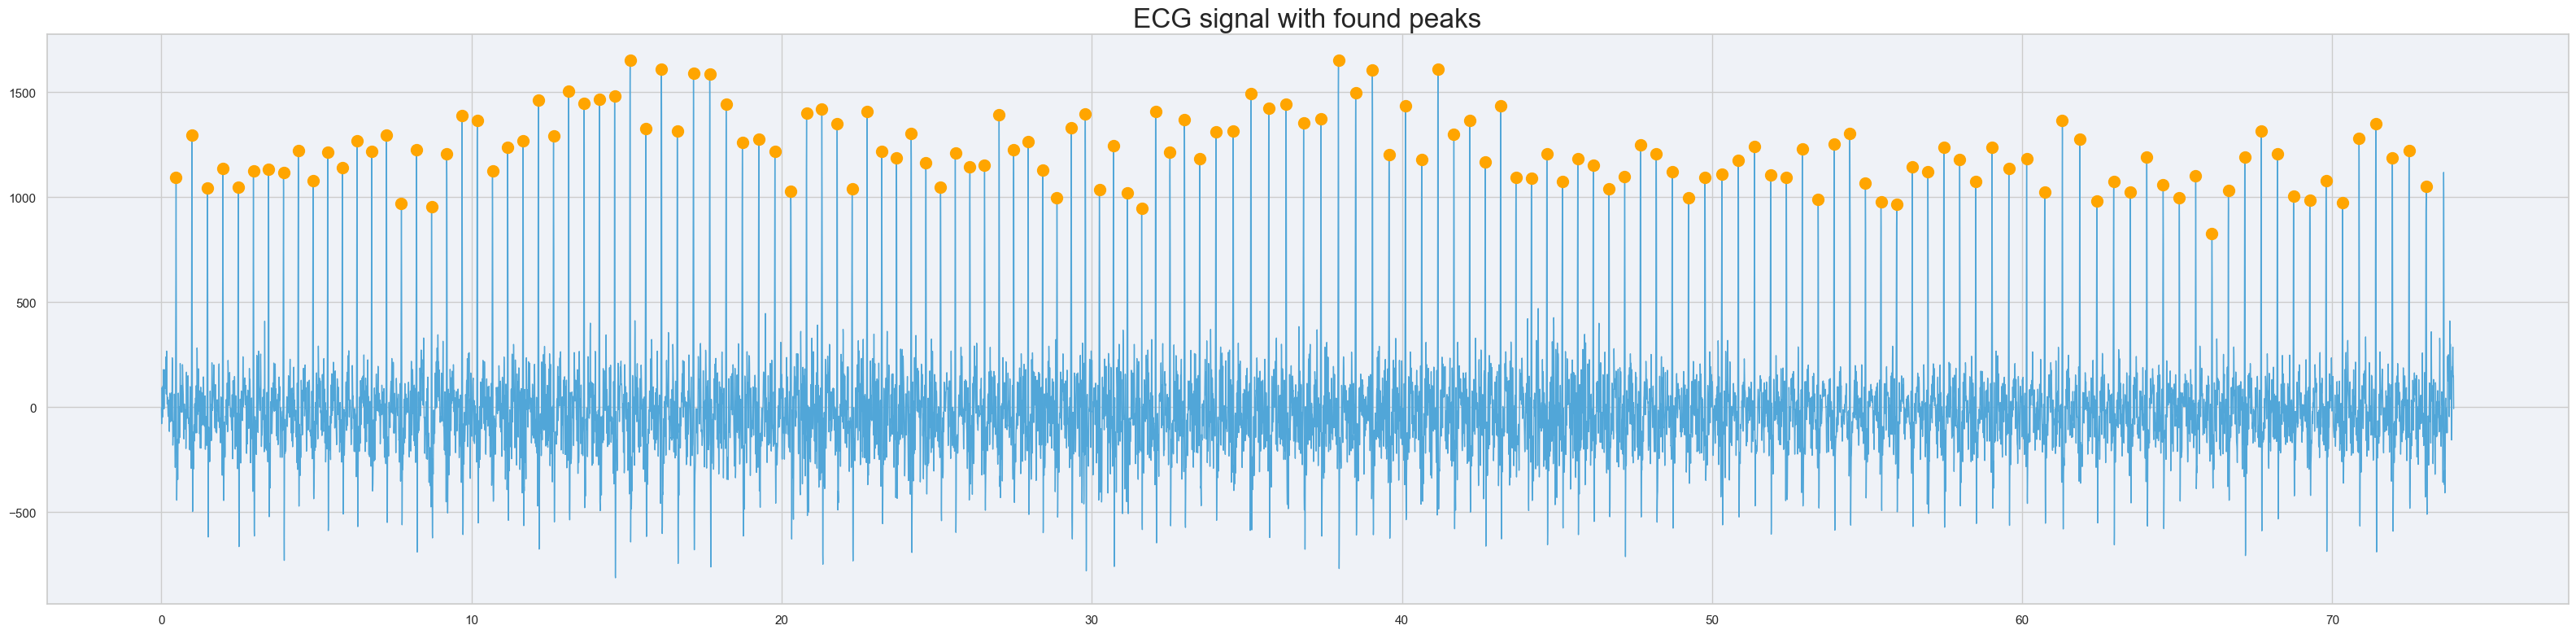

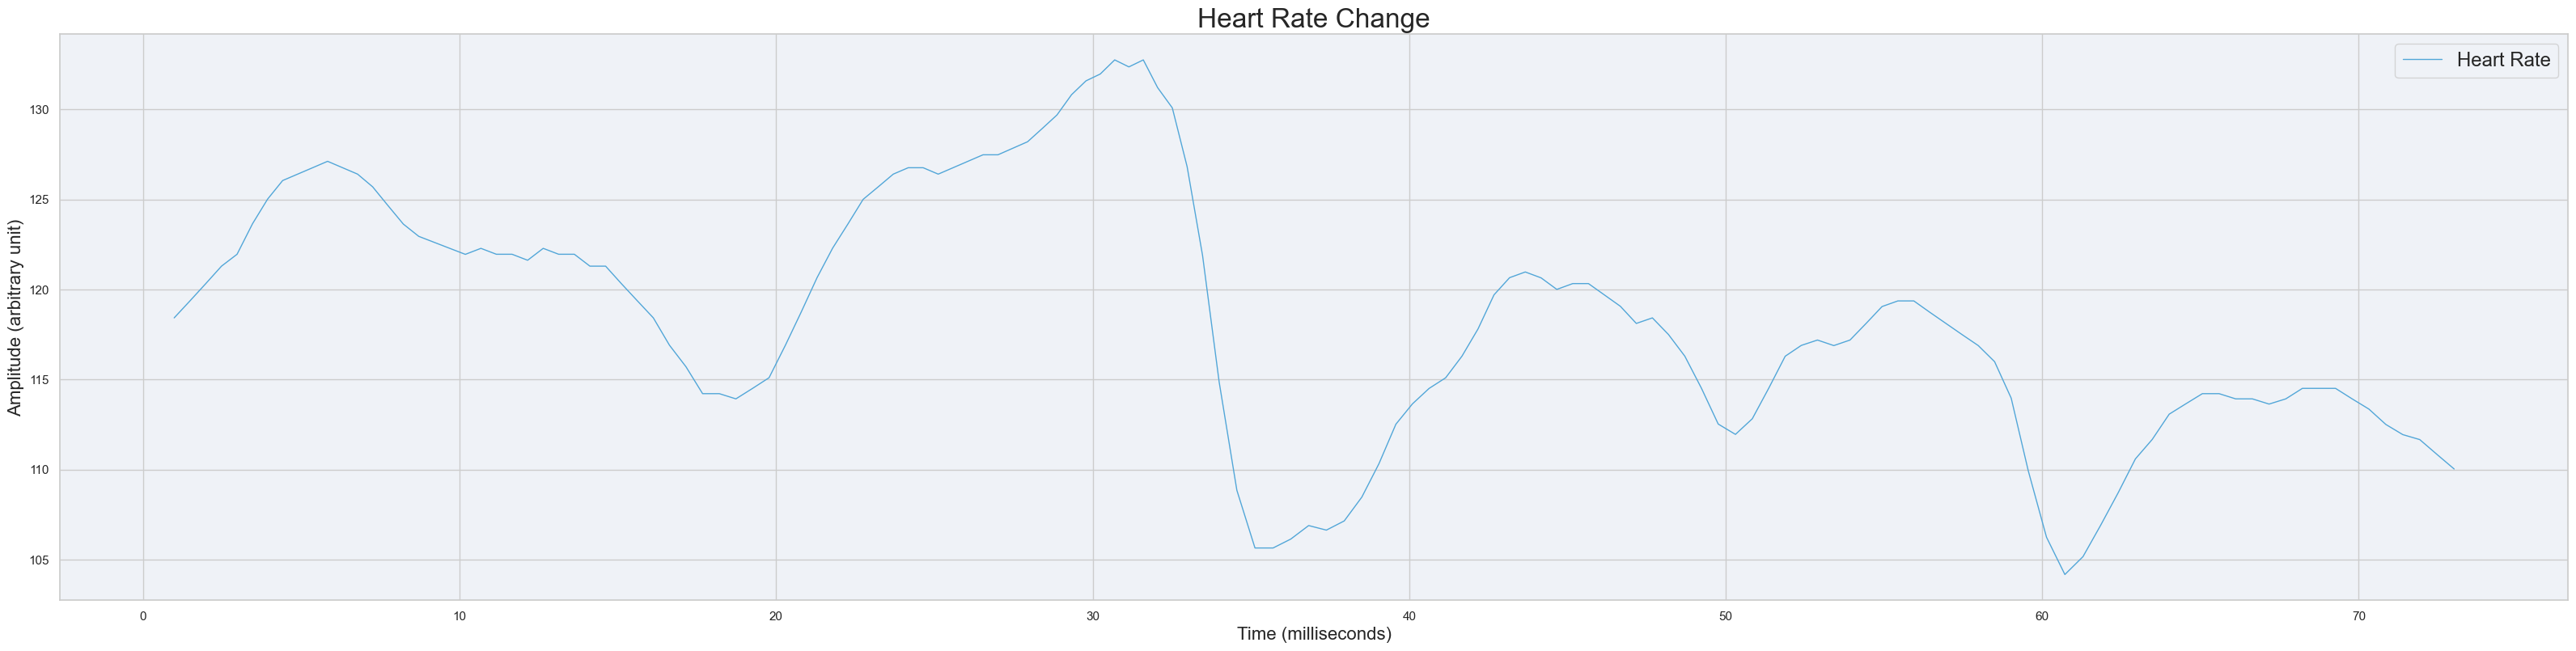

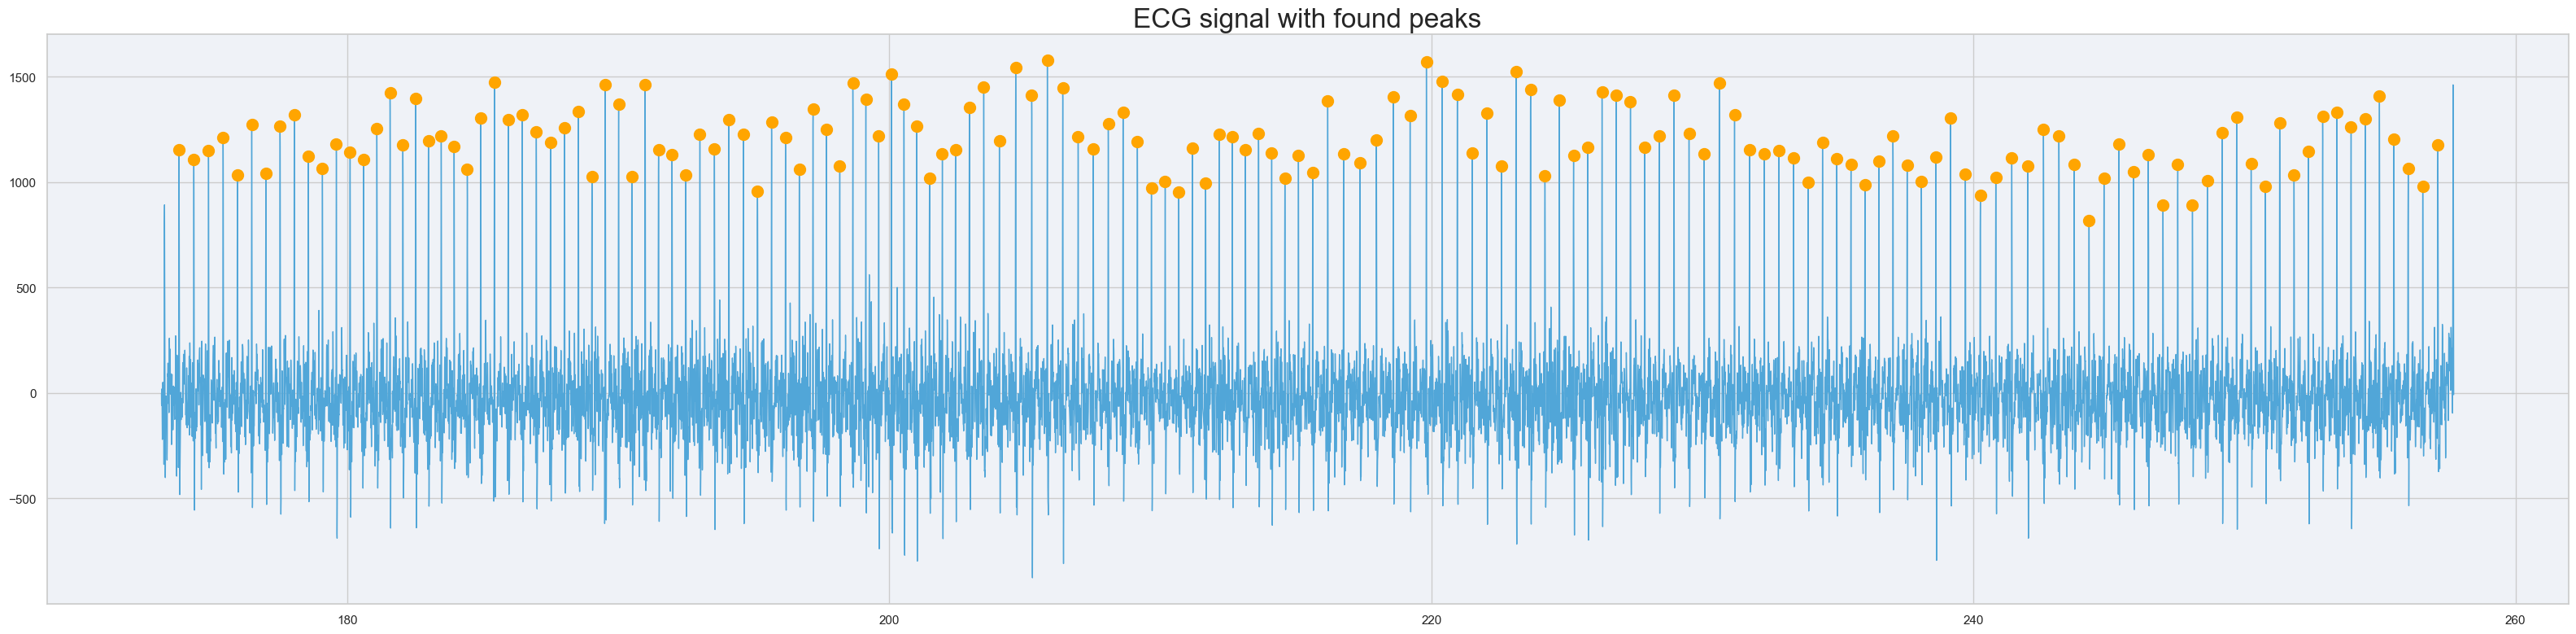

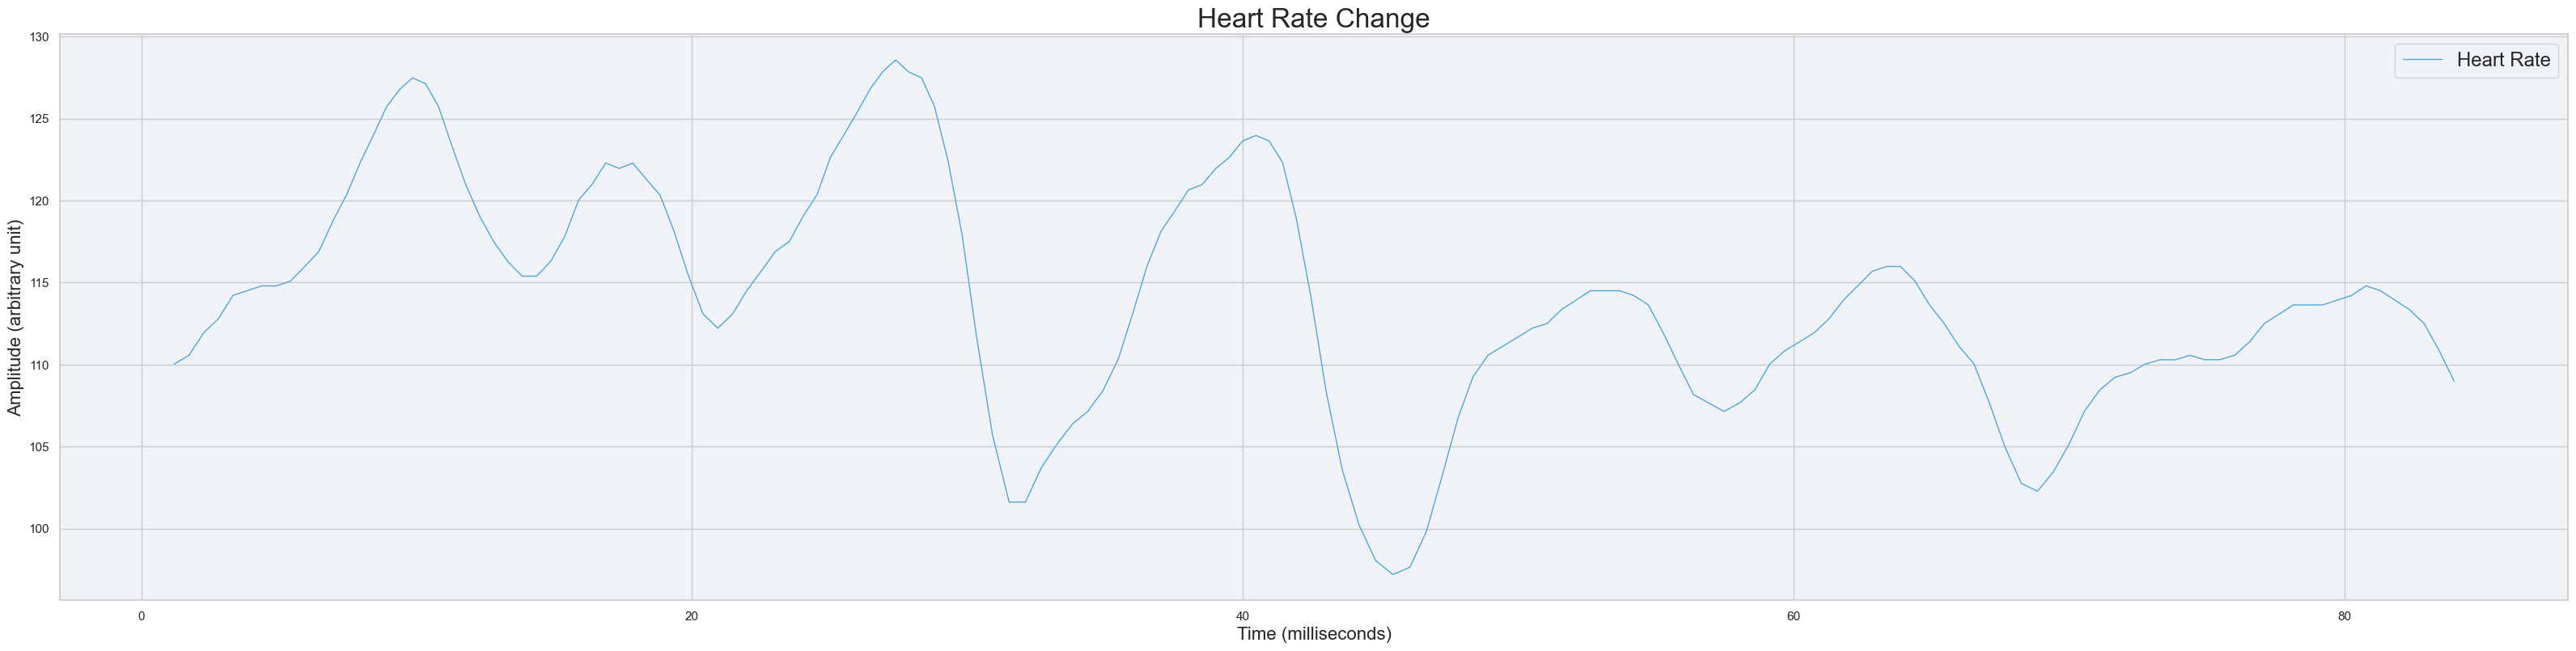

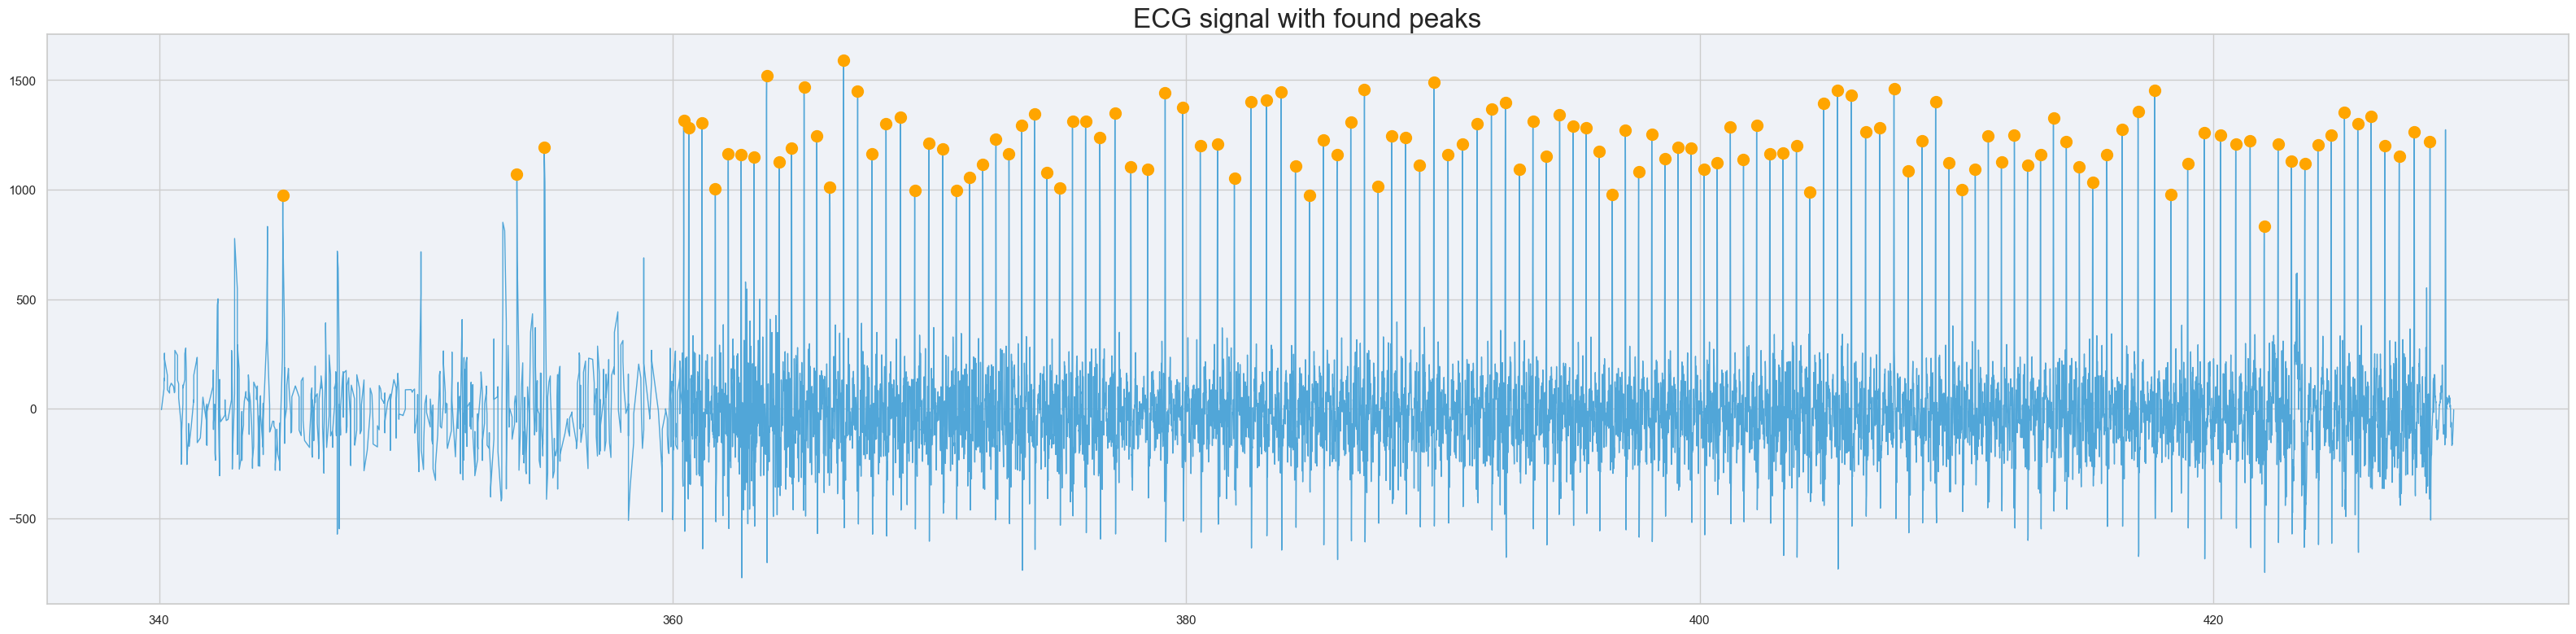

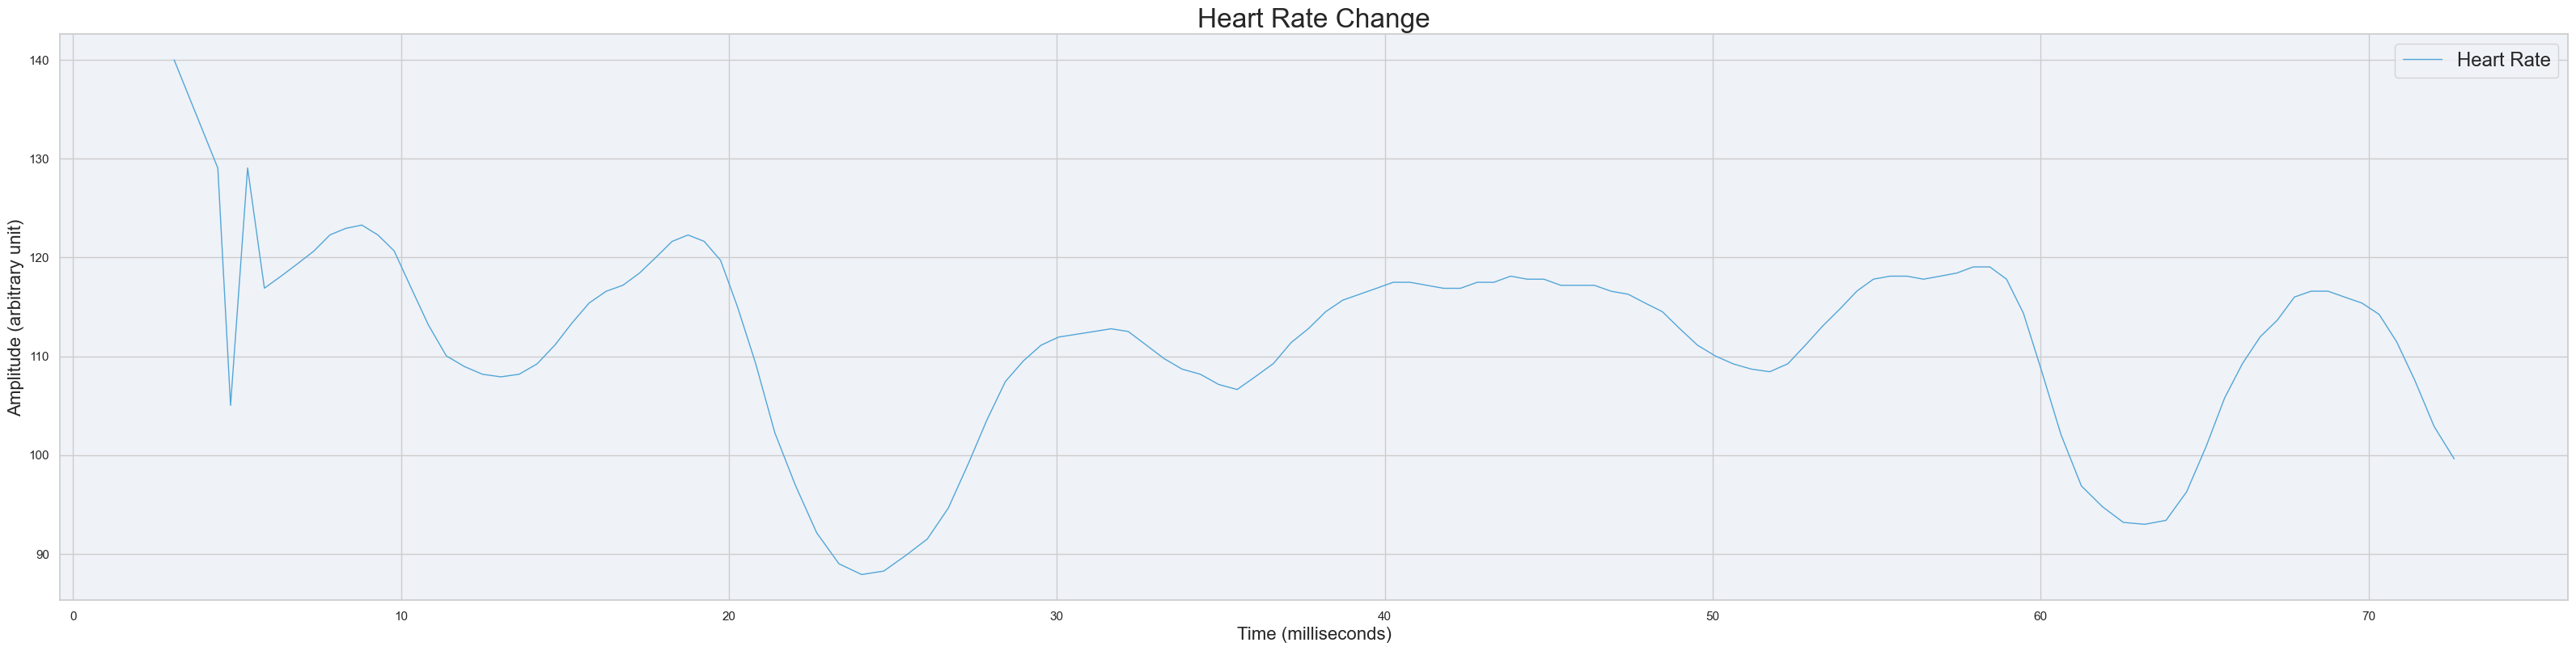

device data length:  (2, 116144)
6339 71334 64995
(6337, 24059) 0
(43054, 60488) 24059
(82068, 98223) 60488
[ 98223 116144] 98223


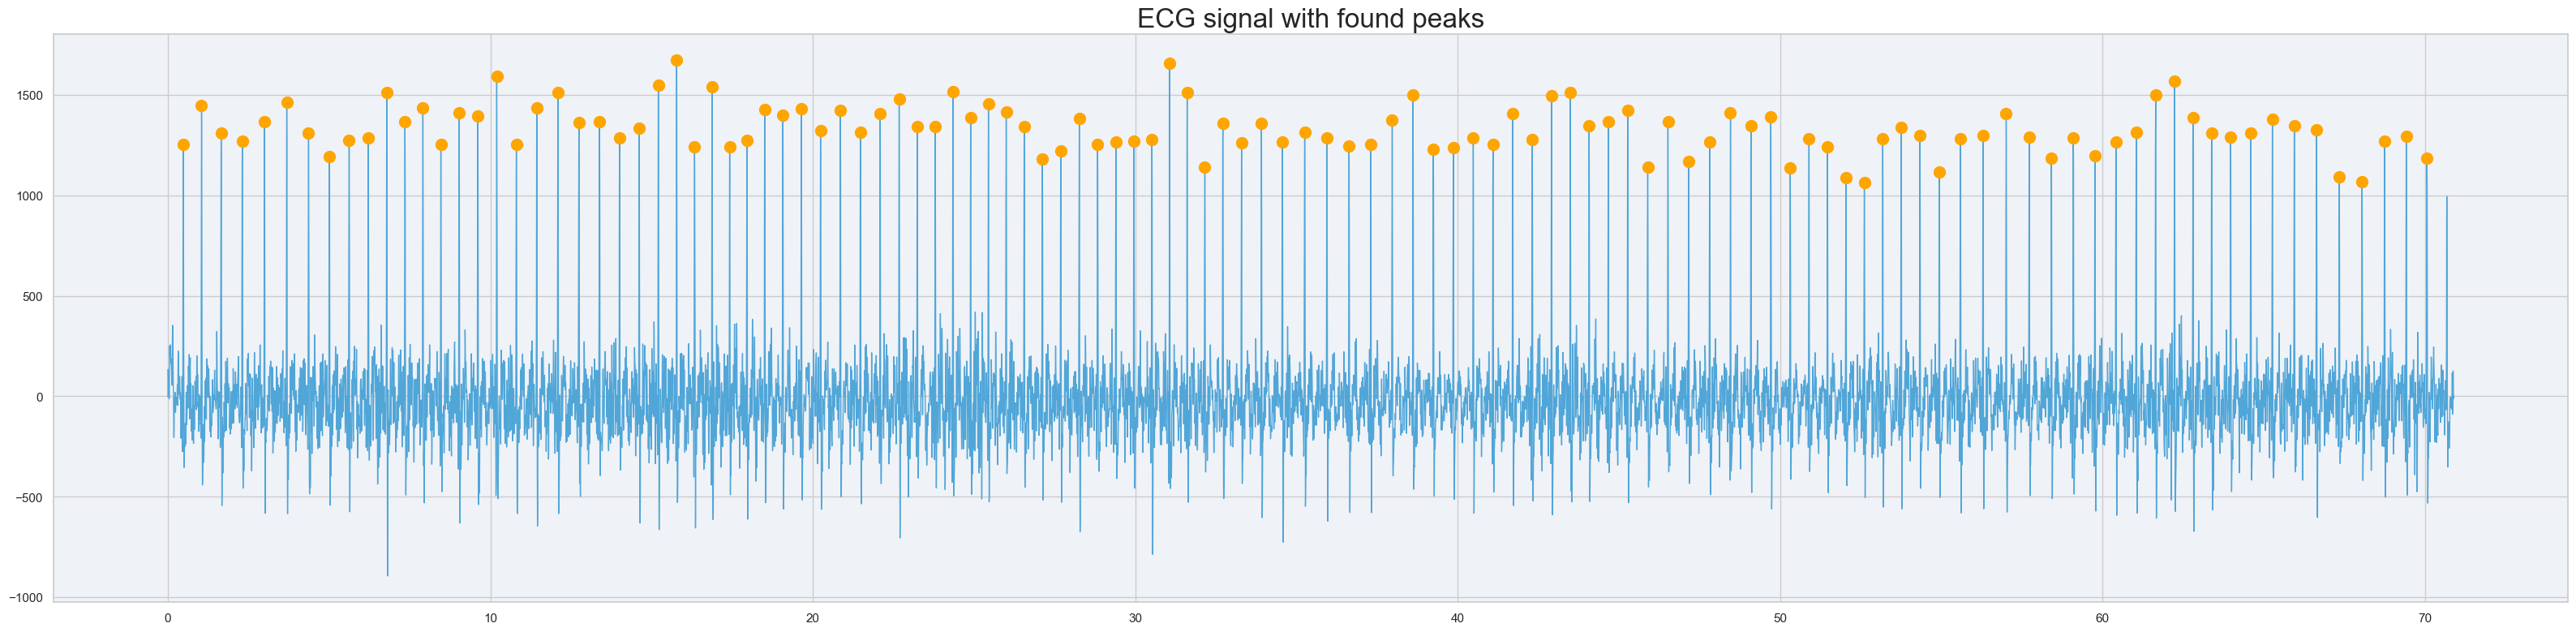

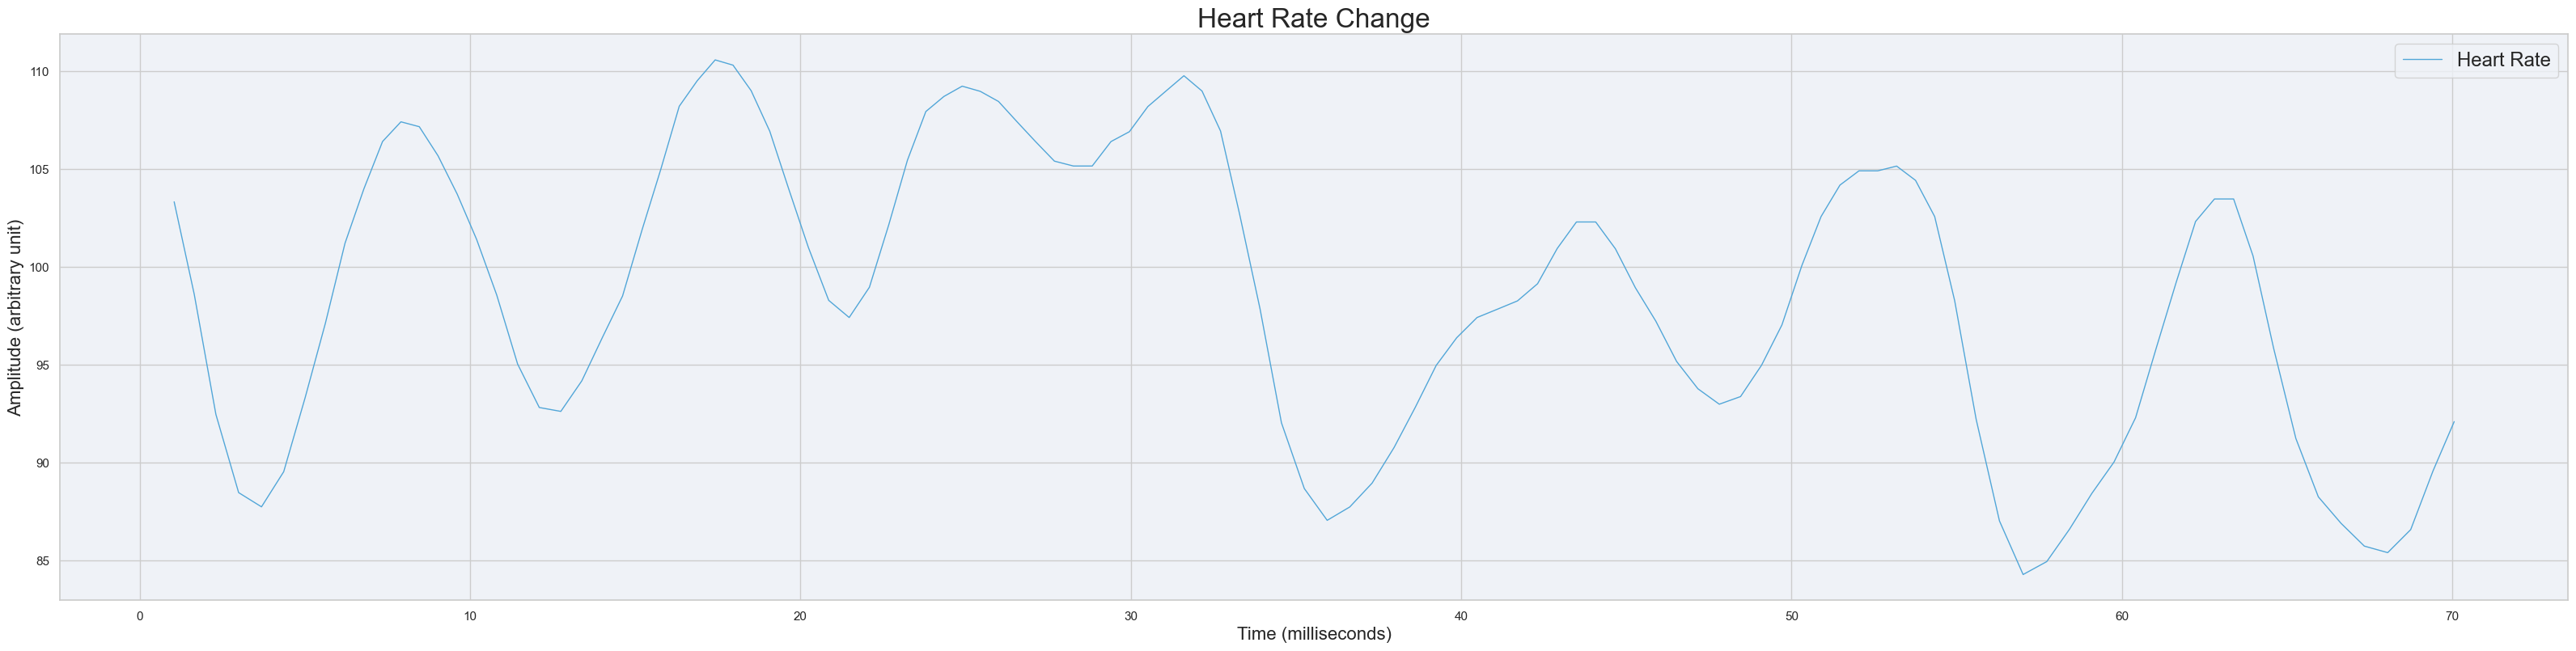

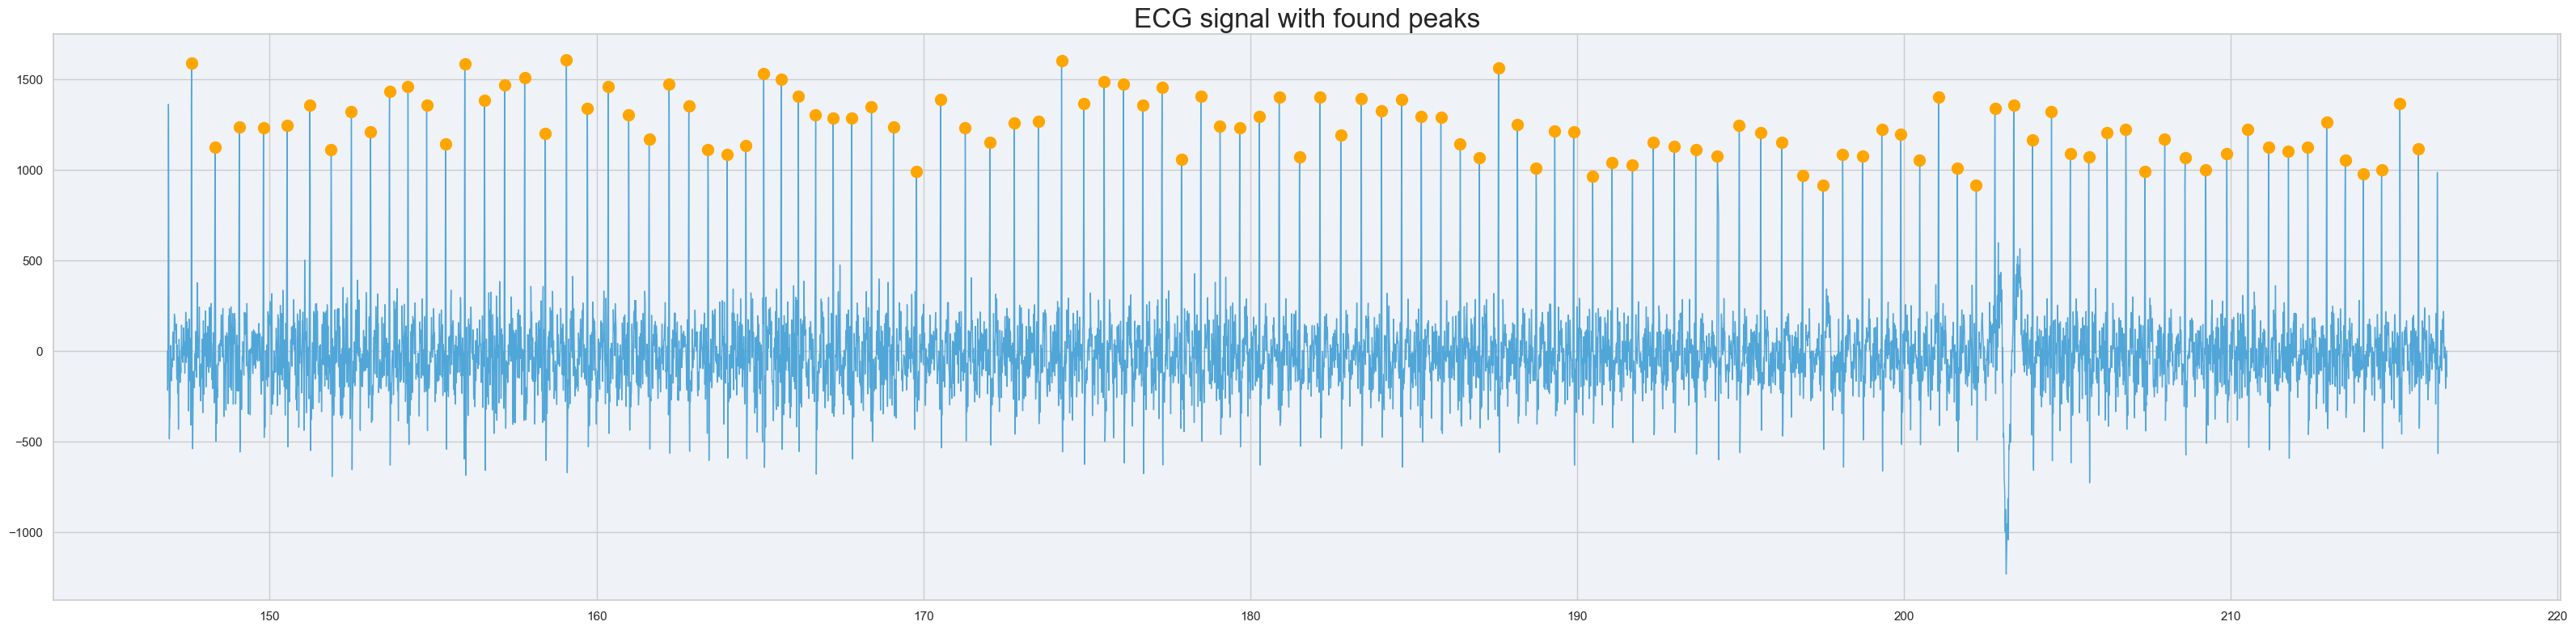

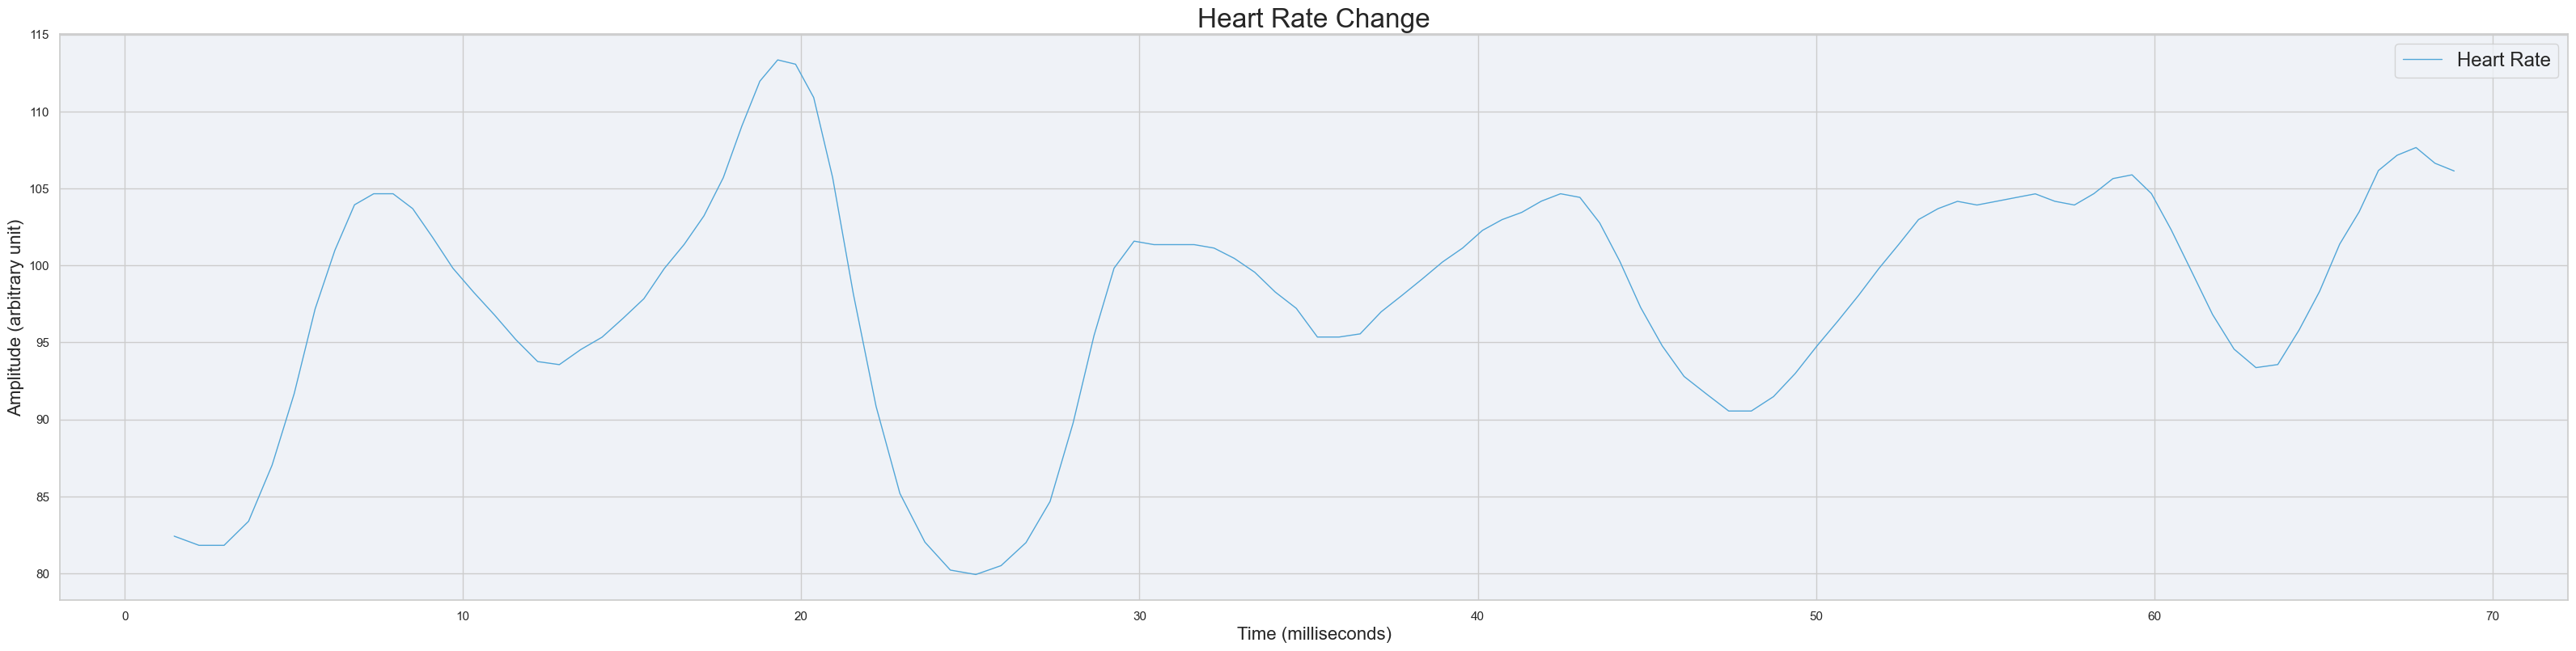

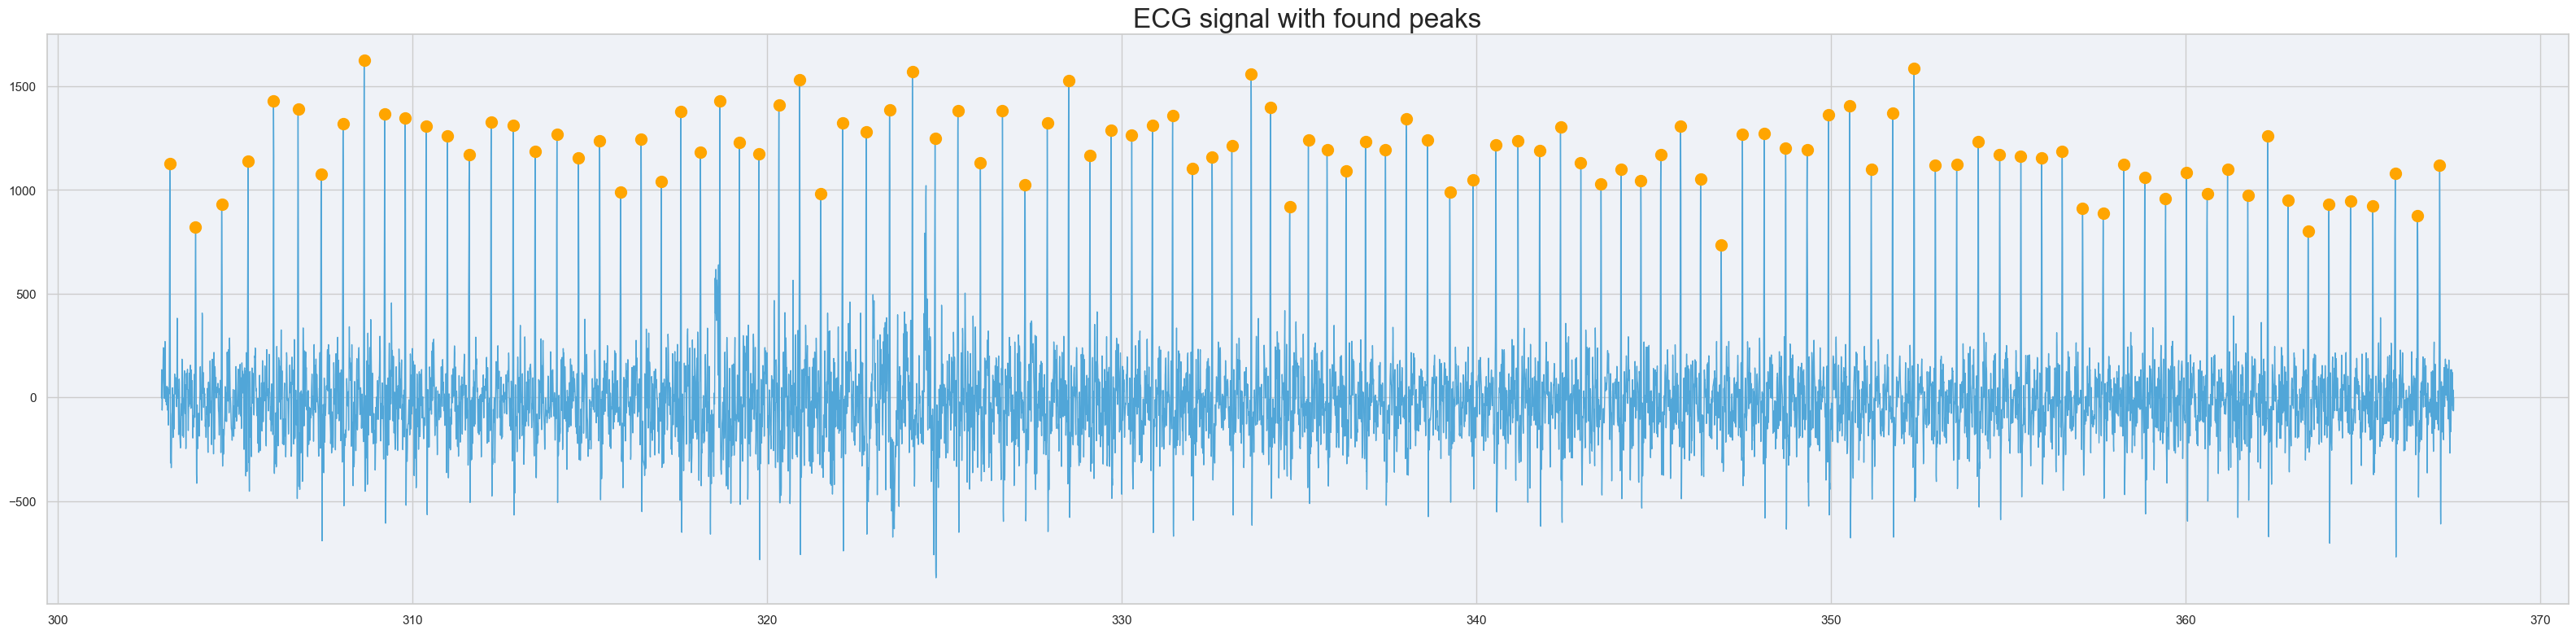

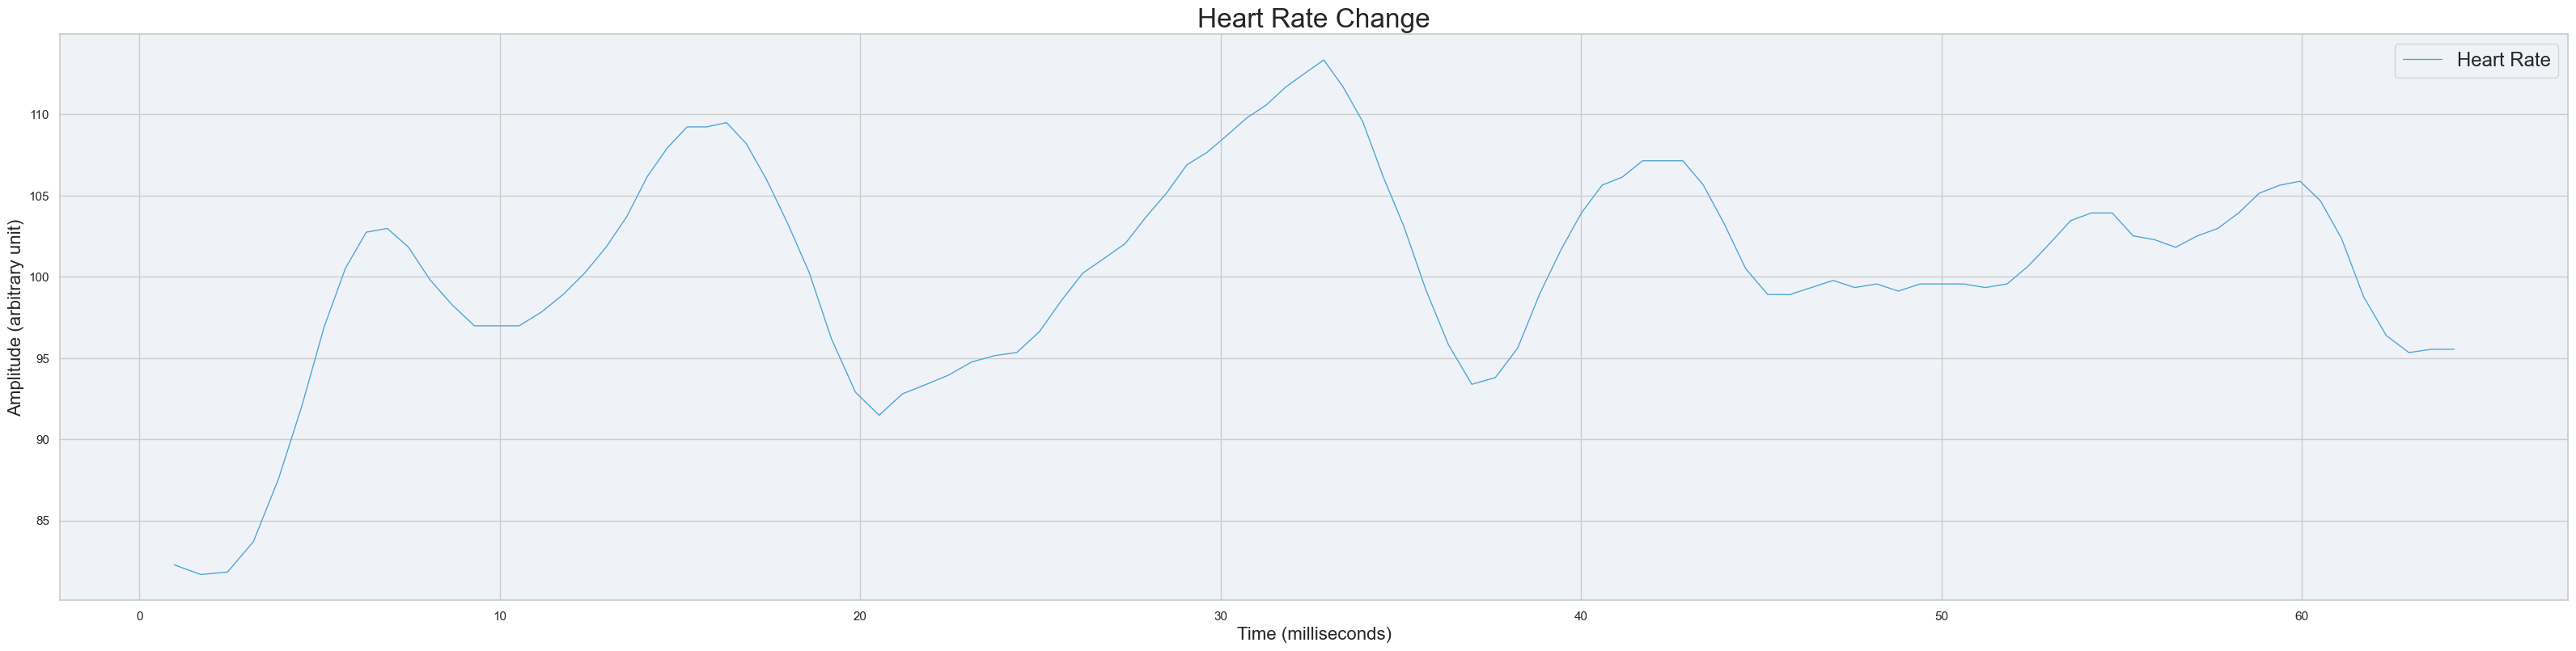

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xb0 in position 37: invalid start byte

In [9]:
current_label = label_options.value

for jf_id, jf in enumerate(filtered_json_files_list[:]):
    times, sensors, duration = get_data_from_json(jf_id, dev_id, channel, False)
    start_time_index = [np.where(
        times==min(times, key=lambda x:abs(x-start_time)))[0][0] for start_time in takes_start_time_s[jf_id]]
    # end_time_seconds = np.add(start_times, durations).tolist()
    end_time_index = [np.where(
        times==min(times, key=lambda x:abs(x-end_time)))[0][0] for end_time in film_durations[jf_id]]
    last_end_index = 0
    for ranges in get_masked_ranges(start_time_index, end_time_index, len(times)):
        print(ranges, last_end_index)
        last_end_index = ranges[1]

    times = times[:] - takes_start_time_s[jf_id][0]
    df = pd.DataFrame({"index": times, "heartrate": sensors})

    df_slice = [pd.DataFrame() for _ in range(len(film_durations[jf_id]))]

    for take, ranges in enumerate(get_masked_ranges(start_time_index, end_time_index, len(times))[:-1]):
        start, stop = ranges
        start_time_seconds = takes_start_time_s[jf_id][take]
        # get slice data of sensor data
        cond_slice = (df.index >= start) & (df.index < stop)
        if (current_label != "ACC"):
            ecg_slice = df.heartrate[cond_slice]
            x_slice = ecg_slice
        else:
            x_slice = df.heartrate[cond_slice]
            ecg_slice = [[acc[0],acc[1],acc[2]] for acc in df.heartrate[cond_slice]]

        df_slice[take] = pd.DataFrame({"index": x_slice, "sensors": ecg_slice})
        # detect peaks
        # peaks, similarity = detect_peaks(ecg_slice, threshold=0.1)
        # normalised_ecg = (ecg_slice - ecg_slice.mean()) / ecg_slice.std()
        if (len(ecg_slice) > 1125):
            if (current_label == "ECG"):
                ecg_stats = ecg.ecg(signal=ecg_slice, sampling_rate=1000/4, show=0)
                ecg_slice_filtered = ecg_stats[1]
                peaks = ecg_stats[2]
                #hrv

            if (current_label == "ACC"):
                ecg_stats = acc.acc(signal=ecg_slice, sampling_rate=1000/10, interactive=0, show=0)

                smv = np.linalg.norm(np.array(ecg_slice), axis=1)
                smv = np.abs(smv)
                ecg_slice_filtered = ecg_stats[1]
                df_slice[take]["magnitude"] = ecg_stats[2]
                first_order_diff = np.diff(smv)
                second_order_diff = np.diff(first_order_diff)
                ecg_slice_filtered = savgol_filter(first_order_diff, window_length=100, polyorder=3)
                signal_series = pd.Series(ecg_slice_filtered)

            if (current_label == "EDA"):
                ecg_stats = eda.eda(signal=ecg_slice, sampling_rate=1000/10, show=1)
                ecg_slice_filtered = ecg_stats[1]
                # Extracted features (SCR, SCL, etc.)
                peaks = ecg_stats[5]
                edl = ecg_stats['edl']  # Skin conductance level
                edr = ecg_stats['edr']  # Skin conductance response
                ecg_slice_filtered = ecg_stats['filtered']  # The filtered EDA signal
        else:
            break

        plt.figure(figsize=(40, 20))
        plt.subplot(211)
        plt.title(f"{current_label} signal with found peaks" if current_label != "ACC" else f"{current_label} signal", fontsize=24)

        if (current_label != "ACC"):
            plt.plot(times[x_slice.index], ecg_slice_filtered, label=current_label, color="#51A6D8", linewidth=1)
            plt.plot(times[peaks+start], ecg_slice_filtered[peaks], markersize=10, label="R-peak", color="orange", marker="o", linestyle="None")

        if (current_label == "ECG"):
            plt.figure(figsize=(40, 20))
            plt.subplot(212)
            plt.title("Heart Rate Change", fontsize=24)
            plt.plot(ecg_stats[5], ecg_stats[6], label="Heart Rate", color="#51A6D8", linewidth=1)

        #    triaxial data
        if (current_label == "ACC"):
            mean = signal_series.rolling(window=100, center=True).mean()
            std = signal_series.rolling(window=100, center=True).std()
            time = np.array(times, dtype=float)
            # time_clean = np.array(time)[valid_mask]
            plt.fill_between(time[x_slice.index][1:], mean - std, mean + std, color='blue', alpha=0.3, label='±1 SD')

        plt.legend(loc="upper right", fontsize="x-large")
        plt.xlabel("Time (milliseconds)", fontsize=16)
        plt.ylabel("Amplitude (arbitrary unit)", fontsize=16)
    plt.show()

## Split by take and windows

In [27]:
takes_start_time_s = [[35.255, 208.39499999999998, 375.365], [25.365, 172.235, 328.295], [57.255, 303.33500000000004, 514.325], [37.325, 257.225, 473.41499999999996, 743.2750000000001], [60.335, 313.325, 477.375], [52.405, 567.2149999999999, 822.365],
                      [56.195, 230.255, 555.235], [194.245, 390.225, 545.255], [285.225, 457.19500000000005, 692.175], [76.245, 408.40500000000003, 614.395], [96.195, 304.255, 454.34499999999997], [34.345, 180.395, 520.335]]

film_durations = [[73.962667, 84.629333, 73.589333], [70.912000, 69.760000, 64.640000],
                  [83.520000, 84.352000, 86.357333], [97.664000, 110.357333, 114.517333, 113.344000],
                  [59.626667, 63.594667, 68.906667], [59.840000, 60.906667, 62.442667],
                  [69.077333, 74.880000, 74.474667], [88.384000, 77.120000, 66.026667],
                  [68.714667, 74.837333, 70.037333], [72.064000, 64.832000, 59.349333],
                  [104.704000, 70.869333, 75.669333], [86.272000, 124.842667, 80.597333]]

show_raw = True

nr_plots = 1

filtered_json_files_list_hrv = [filtered_json_files_list[i] for i in [0,1]]


# phase_labels = [
# "She enters","Goes to the window","He enters","Dialogue","Physical Contact"
# ]

# takes_start_time_padded = [[elem - 3500 for elem in row] for row in takes_start_time_s]

IndexError: list index out of range

In [ ]:
feature_sample_id = 0

# 13 seconds
window_size = int(13000 / 4)

# Files
for jf_id, jf in enumerate(filtered_json_files_list[:]):
    times, sensors, duration = get_data_from_json(jf_id, dev_id, channel, False)
    # takes_start_time = np.array(takes_start_time_s[jf_id]) - int(14000/4)
    start_time_index = [np.where(
        # times==min(times, key=lambda x:abs(x-start_time)))[0][0] for start_time in takes_start_time_s[jf_id]]
        times==min(times, key=lambda x:abs(x-start_time)))[0][0] for start_time in takes_start_time_s[jf_id]]
        # end_time_seconds = np.add(start_times, durations).tolist()
    end_time_index = [np.where(
        times==min(times, key=lambda x:abs(x-end_time)))[0][0] for end_time in film_durations[jf_id]]
    last_end_index = 0
    for ranges in get_masked_ranges(start_time_index, end_time_index, len(times)):
        # print(ranges, last_end_index)
        # sensors = zero_until_range(sensors, ranges[0] if ranges[1] != len(times) else len(times), last_end_index)
        last_end_index = ranges[1]
    times = times[:] - takes_start_time_s[jf_id][0]

    # times, sensors, duration = get_data_from_json(jf_id, dev_id, channel, False)
    df = pd.DataFrame({"index": times, "heartrate": sensors})
    df_slice = [pd.DataFrame() for _ in range(len(film_durations[jf_id]))]

    plot_ranges = []
    # Takes
    for take, ranges in enumerate(get_masked_ranges(start_time_index, end_time_index, len(times))[:-1]):
        print("======Next Take======")
        sampfrom, sampto = ranges

        if current_label == "ECG":
            sampfrom = sampfrom - window_size # - 13s
            sampto = sampfrom + (window_size * 7)
            print("ranges", sampfrom, sampto)
            plot_ranges = split_window(sampfrom, sampto, min_size=window_size)

        if current_label == "EDA" or current_label == "ACC":
            window_size = sampto - sampfrom
            plot_ranges = get_plot_ranges(sampfrom, sampto, nr_plots)

        hrv_graph = [[]]
        eda_graph = [[]]

        print("session, ", identifiers[jf_id])
        print("take: ", take)
        print("processing features for ", current_label)
        # Sampling Windows
        for i, start_stop in enumerate(plot_ranges):
        # for i, start_stop in enumerate(get_plot_ranges(sampfrom, sampto, nr_plots)):
            print("======Next Sampling Window======")
            start, stop = start_stop

            # if (current_label == "ECG"):
            #     start = start - window_size

            print("start_stop: ", start_stop)
            print("times[start], times[stop]: ", times[start], times[stop])
            print("(start / 250) - takes_start_time_s[jf_id][0]: ", (start / 250) - takes_start_time_s[jf_id][0])
            if (78 - times[stop] < 12):
                print("78 - times[stop]: ", 78 - times[stop])

            # get slice data of sensor data
            cond_slice = (df.index >= start) & (df.index < stop)
            if (current_label != "ACC"):
                ecg_slice = df.heartrate[cond_slice]
                x_slice = ecg_slice
            else:
                x_slice = df.heartrate[cond_slice]
                ecg_slice = [[acc[0],acc[1],acc[2]] for acc in df.heartrate[cond_slice]]

            df_slice[take] = pd.DataFrame({"index": x_slice, "sensors": ecg_slice})

            if (len(ecg_slice) > 1125):
                if (current_label == "ECG"):
                    ecg_stats = ecg.ecg(signal=ecg_slice, sampling_rate=1000/4, show=0)
                    t, ecg_slice_filtered, peaks = ecg.ecg(signal=ecg_slice, sampling_rate=1000/4, show=0)[:3]
                    try:
                        hrv_features = hrv.hrv(rpeaks=peaks, sampling_rate=1000/4, outliers="interpolate", show=1, show_individual=False)
                        # print(hrv_features[])
                    except Exception as e:
                        print(f"An error occurred: {e}")
                        pass
                    try:
                        if (hrv_features[10]):
                            print(times[stop], times[sampfrom])
                            hrv_graph.append([times[stop - window_size] - times[sampfrom], hrv_features[10]])
                            # print(hrv_graph)
                        else:
                            continue
                    except Exception as e:
                        print(f"An error occurred: {e}")
                        pass
                    # rri = hrv.rri_correction(rri=hrv_features)
                    # hrv_time_features = hrv.hrv_timedomain(rri=hrv_features, duration=times[stop]-times[start], show=True)
                    # results = td.rmssd(nni=rri)
                if (current_label == "ACC"):
                    ecg_stats = acc.acc(signal=ecg_slice, sampling_rate=1000/10, interactive=0, show=0)
                    # ecg_slice_filtered = ecg_stats[1]
                    df_slice[take]["magnitude"] = ecg_stats[2]
                    df_slice[take]["smoothed"] = df_slice[take]["magnitude"].ewm(alpha=0.25, adjust=False).mean()
                    ecg_slice_filtered = df_slice[take]["smoothed"]

                    n_parts = 2
                    split_signals = np.array_split(ecg_stats[1], n_parts)
                    for i, window in enumerate(split_signals):
                        spectrum_features = acc.frequency_domain_feature_extractor(signal=window, sampling_rate=1000/10)
                        plt.figure(figsize=(3, 3))
                        for axs in ["x", "y", "z"]:
                            plt.plot(spectrum_features[0][axs], spectrum_features[1][axs])
                        plt.xlim(0.0, 1.0)
                        plt.show()
                if (current_label == "EDA"):
                    try:
                        ecg_stats = eda.eda(signal=ecg_slice, sampling_rate=1000/10, show=0)
                        ecg_slice_filtered = ecg_stats[1]
                        # Extracted features (SCR, SCL, etc.)
                        peaks = ecg_stats[5]
                        onsets = ecg_stats['onsets']
                        edl = ecg_stats['edl']  # Skin conductance level
                        edr = ecg_stats['edr']  # Skin conductance response
                        ecg_slice_filtered = ecg_stats['filtered']  # The filtered EDA signal

                        eda_graph = [times[onsets] + takes_start_time_s[jf_id][0], times[peaks] + takes_start_time_s[jf_id][0]]
                        # print(eda_graph)
                    except Exception as e:
                        eda_graph = [[], []]
                        print(f"An error occurred: {e}")
            else:
                break

            if (show_raw):
                plt.figure(figsize=(40, 20))
                plt.subplot(211)
                plt.title(f"{current_label} signal with found peaks {identifiers[jf_id]} {take}" if current_label != "ACC" else f"{current_label} signal", fontsize=24)

            if (current_label != "ACC" and show_raw):
                plt.plot(times[ecg_slice.index] - times[x_slice.index][0], ecg_slice_filtered, label=current_label, color="#51A6D8", linewidth=1)
                plt.plot(times[peaks+start] - times[x_slice.index][0], ecg_slice_filtered[peaks], markersize=10, label="R-peak", color="orange", marker="o", linestyle="None")
        #    triaxial data
            if (current_label == "ACC"):
                # plt.plot(times[x_slice.index], ecg_slice_filtered, label=current_label, color="#51A6D8", linewidth=3)
                # plt.plot(times[x_slice.index], (1*df_slice["second_order_diff"]) + 1, label=current_label, color="orange", linewidth=3)
                sns.lineplot(x=times[x_slice.index], y=ecg_slice_filtered,estimator=np.mean, errorbar='sd')
                plt.ylim(0.9, 1.1)
                # plt.annotate('This point is interesting!', xy=(0, 1), xytext=(0, 1), arrowprops=dict(facecolor='black', shrink=0.05))

            if (current_label == "ECG" and show_raw):
                plt.figure(figsize=(40, 20))
                plt.subplot(212)
                plt.title("Heart Rate Change", fontsize=24)
                plt.plot(ecg_stats[5], ecg_stats[6], label="Heart Rate", color="#51A6D8", linewidth=1)

            if (show_raw):
                plt.legend(loc="upper right", fontsize=20)
                plt.xlabel("Time (milliseconds)", fontsize=16)
                plt.ylabel("Amplitude (arbitrary unit)", fontsize=16)
                plt.show()


        if (current_label == "ECG"):
            print("List is not empty" if len(hrv_graph[1])>0 else "List is empty")
            print(hrv_graph)
            if len(hrv_graph[1])>0:
                df_features[feature_sample_id] = pd.DataFrame(hrv_graph, columns=['x', 'y'])
            else:
                print("nothing here")
                result_df = pd.DataFrame({"x": np.linspace(0, 78, num=(78//13) + 1, dtype=int), "y": 0})
                df_features[feature_sample_id] = pd.DataFrame(result_df, columns=['x', 'y'])
            feature_sample_id += 1

#         if (current_label == "EDA"):
#             eda_window_split = int(13)
#             arr_np = np.array(eda_graph[1], dtype=float)
#             print(eda_graph[1])
#             print("List is not empty" if len(eda_graph[1])>0 else "List is empty")
#             if len(eda_graph[1])>0:
#                 peak_index_list = np.array(sorted(eda_graph[1]), dtype=int)
#                 bins = np.arange(0, peak_index_list.max() + 13, 13)
#                 bin_labels = bins[:-1]  # Use bin start values as labels
#                 counts, _ = np.histogram(peak_index_list, bins)
#                 result_df = pd.DataFrame({"x": bin_labels, "y": counts})
#                 df_features[feature_sample_id] = pd.DataFrame(result_df, columns=['x', 'y'])
#                 print(df_features[feature_sample_id])
#             else:
#                 print("no peaks here")
#                 result_df = pd.DataFrame({"x": np.linspace(0, 78, num=(78//13) + 1, dtype=int), "y": 0})
#                 df_features[feature_sample_id] = pd.DataFrame(result_df, columns=['x', 'y'])
#                 print(df_features[feature_sample_id])
#             feature_sample_id += 1
#
# if (current_label == "ECG"):
#     df_features[3]["y"].iloc[-1] = df_features[3]["y"].iloc[-1] - 54.0